<a href="https://colab.research.google.com/github/FirefoxSRV/GlassClassification/blob/beta/GlassClassification_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [94]:
data = pd.read_csv("glass.csv")
X = data.drop(["Type"], axis=1)
y = data["Type"]

In [95]:
print(X.columns)

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe'], dtype='object')


In [96]:
print(y)

0      1
1      1
2      1
3      1
4      1
      ..
209    7
210    7
211    7
212    7
213    7
Name: Type, Length: 214, dtype: int64


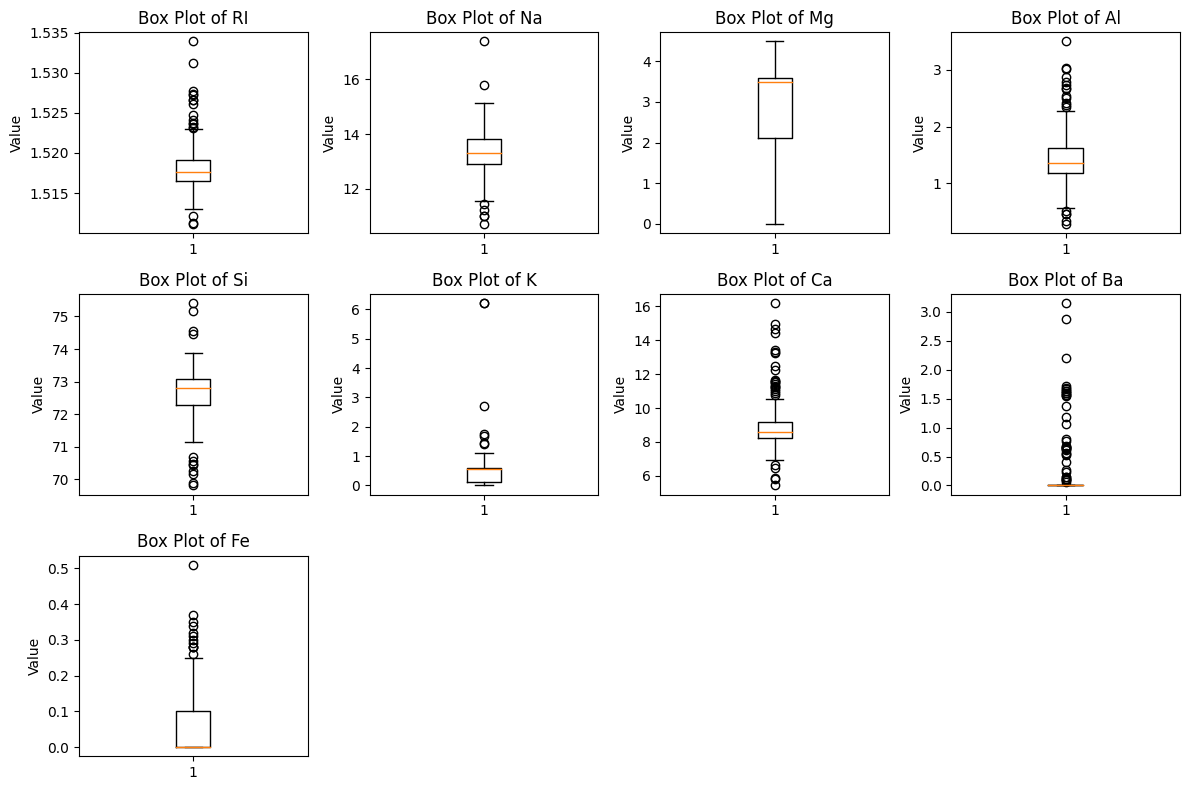

In [97]:
plt.figure(figsize=(12, 8))
for i, feature in enumerate(X.columns):
    plt.subplot(3, 4, i + 1)
    plt.boxplot(X[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [98]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [99]:
knn = KNeighborsClassifier()

param_dist = {
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=100, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='accuracy')

In [100]:
best_params = random_search.best_params_

best_knn = KNeighborsClassifier(metric=best_params['metric'],weights=best_params['weights'])

best_knn.fit(X_train, y_train)

y_pred = best_knn.predict(X_test)

In [101]:
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:", accuracy)
print("Best Hyperparameters:", best_params)

Accuracy: 0.8372093023255814
Best Hyperparameters: {'weights': 'distance', 'metric': 'manhattan'}


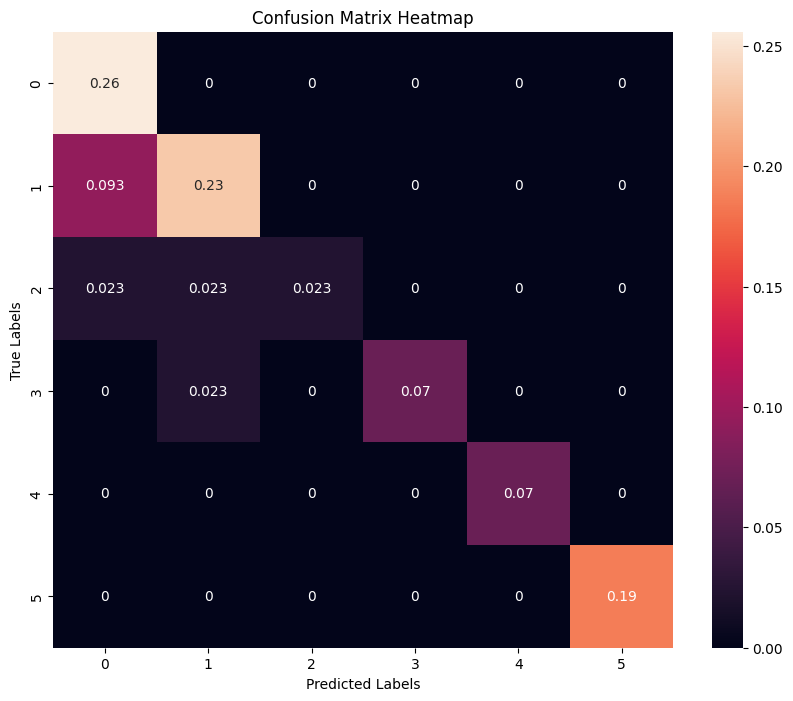

0.8372093023255814

In [102]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
normalized_cm = cm / cm.sum()
sns.heatmap(normalized_cm, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
accuracy_score(y_test, y_pred)